In [21]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pickle as pkl

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

In [22]:
# Import train,test,val image names from given datafiles  

train_image_names = open('./Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt','r').read().splitlines()
val_image_names = open('./Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt','r').read().splitlines()
test_image_names = open('./Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt','r').read().splitlines()
image_path = './Flickr8K/Flicker8K_Images/'

In [23]:
# image_path = '../input/flickr8k/Images'

In [24]:
train_indices = {}
test_indices = {}
val_indices = {}
with open('Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt', 'r') as file:
  for line in file:
    l = line.strip()
    train_indices[l] = 1
with open('Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt', 'r') as file:
  for line in file:
    l = line.strip()
    test_indices[l] = 1 
with open('Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt', 'r') as file:
  for line in file:
    l = line.strip()
    val_indices[l] = 1

In [25]:
def create_captions_dataset(file_type,indices):
    captions = []
    with open('Flickr8K/Flickr8k_text/Flickr8k.token.txt', 'r') as file:
        for line in file:
            l = line.strip()
            s = l.split("#")
            t = s[1].split("\t")
            if(s[0]) in indices:
                captions.append([s[0],t[1]])
            else: continue 
    df_caption = pd.DataFrame(captions)
    df_caption.columns = ["image","caption"]
    df_caption.to_csv(file_type)


In [26]:
create_captions_dataset("test_captions.csv",test_indices)
create_captions_dataset("train_captions.csv",train_indices)
create_captions_dataset("val_captions.csv",val_indices)


In [27]:
data = pd.read_csv("train_captions.csv")
data.drop(labels = ['Unnamed: 0'], axis = 1, inplace=True)
data.head()

image   
0  1000268201_693b08cb0e.jpg  \
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [28]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"./Flickr8K/Flicker8K_Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

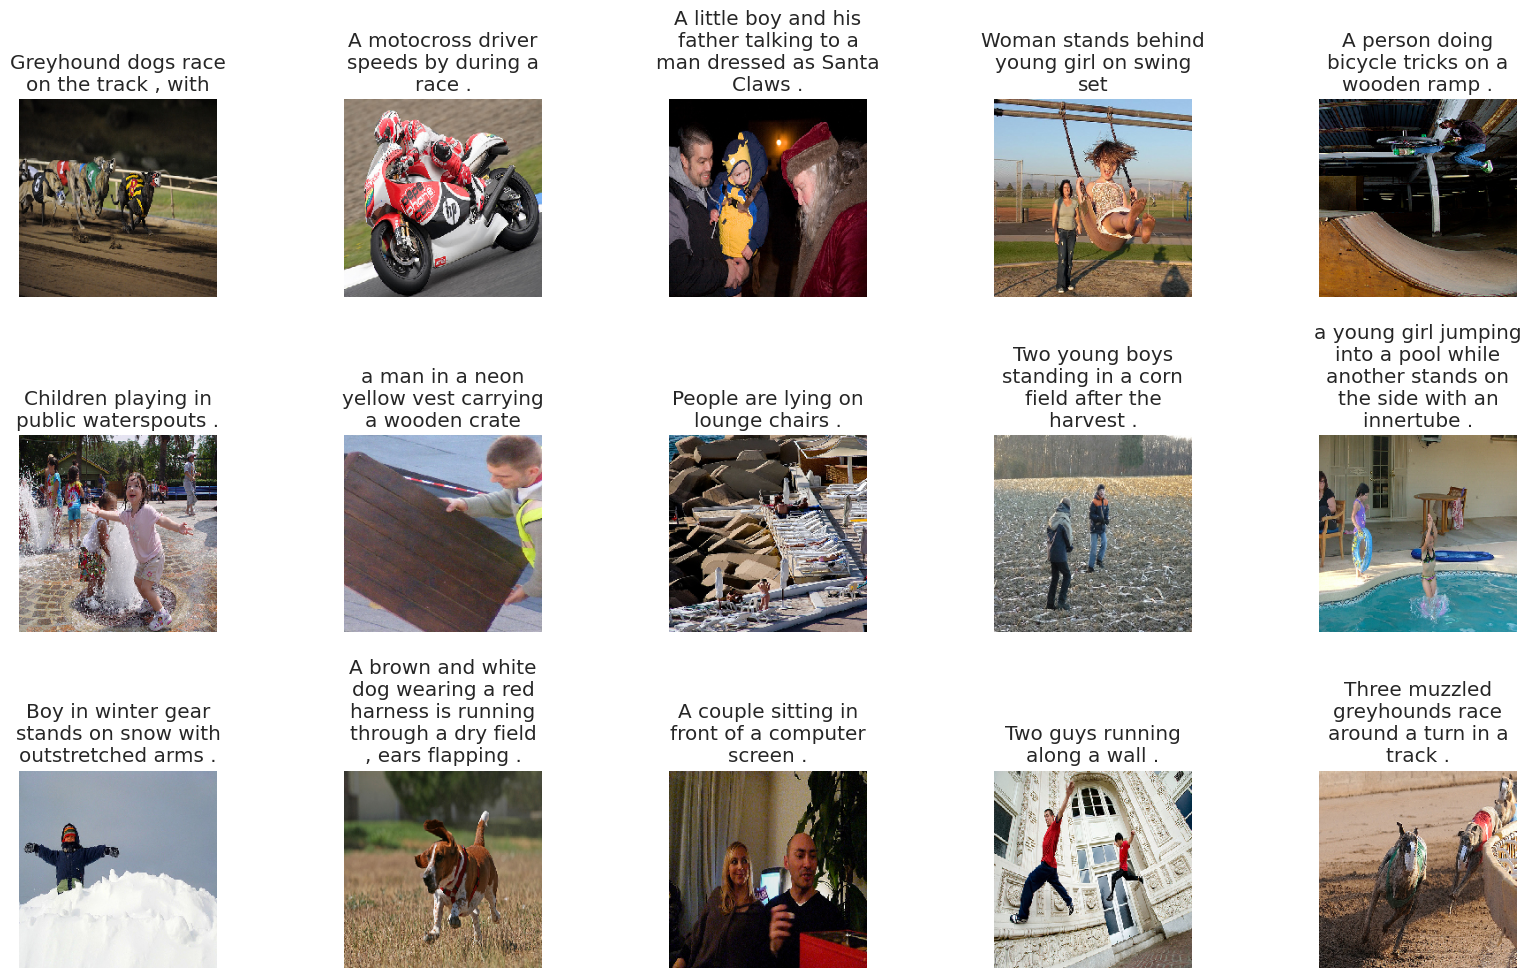

In [29]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [30]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [31]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [32]:
val_data = pd.read_csv("val_captions.csv")
val_data.drop(labels = ['Unnamed: 0'], axis = 1, inplace=True)
val_data.head()

image   
0  1022454332_6af2c1449a.jpg  \
1  1022454332_6af2c1449a.jpg   
2  1022454332_6af2c1449a.jpg   
3  1022454332_6af2c1449a.jpg   
4  1022454332_6af2c1449a.jpg   

                                             caption  
0  A child and a woman are at waters edge in a bi...  
1  a large lake with a lone duck swimming in it w...  
2           A little boy at a lake watching a duck .  
3  A young boy waves his hand at the duck in the ...  
4  Two people are at the edge of a lake , facing ...

In [33]:
val_data = text_preprocessing(val_data)
val_captions = data['caption'].tolist()
val_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

train_images = data['image'].unique().tolist()
val_images = val_data['image'].unique().tolist()
# nimages = len(images)

# split_index = round(0.85*nimages)
# train_images = images[:split_index]
# val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = val_data[val_data['image'].isin(val_images)]

# train.reset_index(inplace=True,drop=True)
# test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 64, 196, 119, 2]

In [59]:
test

image   
0     1022454332_6af2c1449a.jpg  \
1     1022454332_6af2c1449a.jpg   
2     1022454332_6af2c1449a.jpg   
3     1022454332_6af2c1449a.jpg   
4     1022454332_6af2c1449a.jpg   
...                         ...   
4995   989851184_9ef368e520.jpg   
4996   989851184_9ef368e520.jpg   
4997   989851184_9ef368e520.jpg   
4998   989851184_9ef368e520.jpg   
4999   989851184_9ef368e520.jpg   

                                                caption  
0     startseq child and woman are at waters edge in...  
1     startseq large lake with lone duck swimming in...  
2      startseq little boy at lake watching duck endseq  
3     startseq young boy waves his hand at the duck ...  
4     startseq two people are at the edge of lake fa...  
...                                                 ...  
4995  startseq black dog has dumbbell in his mouth e...  
4996  startseq black dog has dumbbell in his mouth l...  
4997  startseq black dog holding weight in its mouth...  
4998  startseq black dog holds small white dumbbell ...  
4999  startseq the black dog has toy in its mouth an...  

[5000 rows x 2 columns]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

In [43]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(val_data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 1000/1000 [01:43<00:00,  9.62it/s]


In [44]:
# filename = 'cnn_val_features2.pickle'
# file = open(filename, 'wb')
# pkl.dump(features,file)

In [35]:
filename = 'cnn_train_features2.pickle'
file = open(filename, 'rb')
trainImg_features = pkl.load(file)

In [45]:
filename = 'cnn_val_features2.pickle'
file = open(filename, 'rb')
valImg_features = pkl.load(file)

# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [36]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [60]:
max_length

34

In [37]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

2023-05-14 09:53:52.268387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-14 09:53:52.402366: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-14 09:53:52.639653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gra

In [39]:
from tensorflow.keras.utils import plot_model

## **Model Modification**
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

In [40]:
plot_model(caption_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [41]:
caption_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                              

In [61]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=trainImg_features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=valImg_features)

In [62]:
model_name = "model2.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

### Training

In [63]:
history = caption_model.fit(
        train_generator,
        epochs=12,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/12


2023-05-14 11:35:27.940262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


468/468 [==============================] - ETA: 0s - loss: 2.9459

2023-05-14 11:53:06.103075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-14 11:53:06.389823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 11:53:06.391549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: val_loss improved from inf to 3.78947, saving model to model2.h5
468/468 [==============================] - 1128s 2s/step - loss: 2.9459 - val_loss: 3.7895 - lr: 0.0010
Epoch 2/12
468/468 [==============================] - ETA: 0s - loss: 2.9128
Epoch 2: val_loss did not improve from 3.78947
468/468 [==============================] - 245s 523ms/step - loss: 2.9128 - val_loss: 3.8235 - lr: 0.0010
Epoch 3/12
468/468 [==============================] - ETA: 0s - loss: 2.8956
Epoch 3: val_loss did not improve from 3.78947
468/468 [==============================] - 252s 538ms/step - loss: 2.8956 - val_loss: 3.8423 - lr: 0.0010
Epoch 4/12
468/468 [==============================] - ETA: 0s - loss: 2.8800
Epoch 4: val_loss did not improve from 3.78947

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
468/468 [==============================] - 246s 525ms/step - loss: 2.8800 - val_loss: 3.8698 - lr: 0.0010
Epoch 5/12
468/468 [==============================] -

# **Inference**
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

In [67]:
history

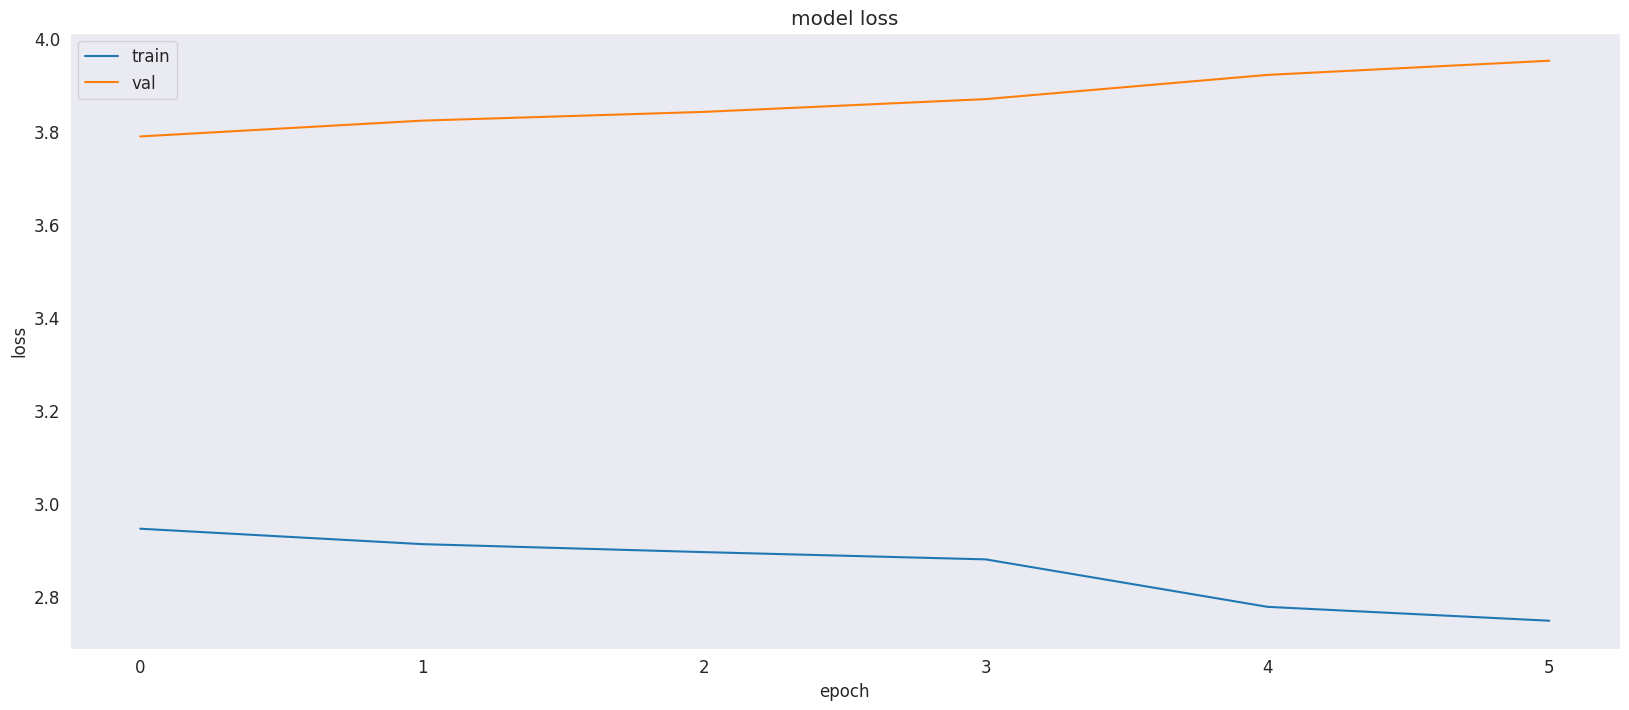

In [68]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [65]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [69]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

## **Taking 15 Random Samples for Caption Prediction**

In [90]:
test

image   
0     1022454332_6af2c1449a.jpg  \
1     1022454332_6af2c1449a.jpg   
2     1022454332_6af2c1449a.jpg   
3     1022454332_6af2c1449a.jpg   
4     1022454332_6af2c1449a.jpg   
...                         ...   
4995   989851184_9ef368e520.jpg   
4996   989851184_9ef368e520.jpg   
4997   989851184_9ef368e520.jpg   
4998   989851184_9ef368e520.jpg   
4999   989851184_9ef368e520.jpg   

                                                caption  
0     startseq child and woman are at waters edge in...  
1     startseq large lake with lone duck swimming in...  
2      startseq little boy at lake watching duck endseq  
3     startseq young boy waves his hand at the duck ...  
4     startseq two people are at the edge of lake fa...  
...                                                 ...  
4995  startseq black dog has dumbbell in his mouth e...  
4996  startseq black dog has dumbbell in his mouth l...  
4997  startseq black dog holding weight in its mouth...  
4998  startseq black dog holds small white dumbbell ...  
4999  startseq the black dog has toy in its mouth an...  

[5000 rows x 2 columns]

In [70]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [71]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 23ms/step


2023-05-14 12:16:06.626448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 12:16:06.627601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 12:16:06.628613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 24ms/step


# **Results**
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

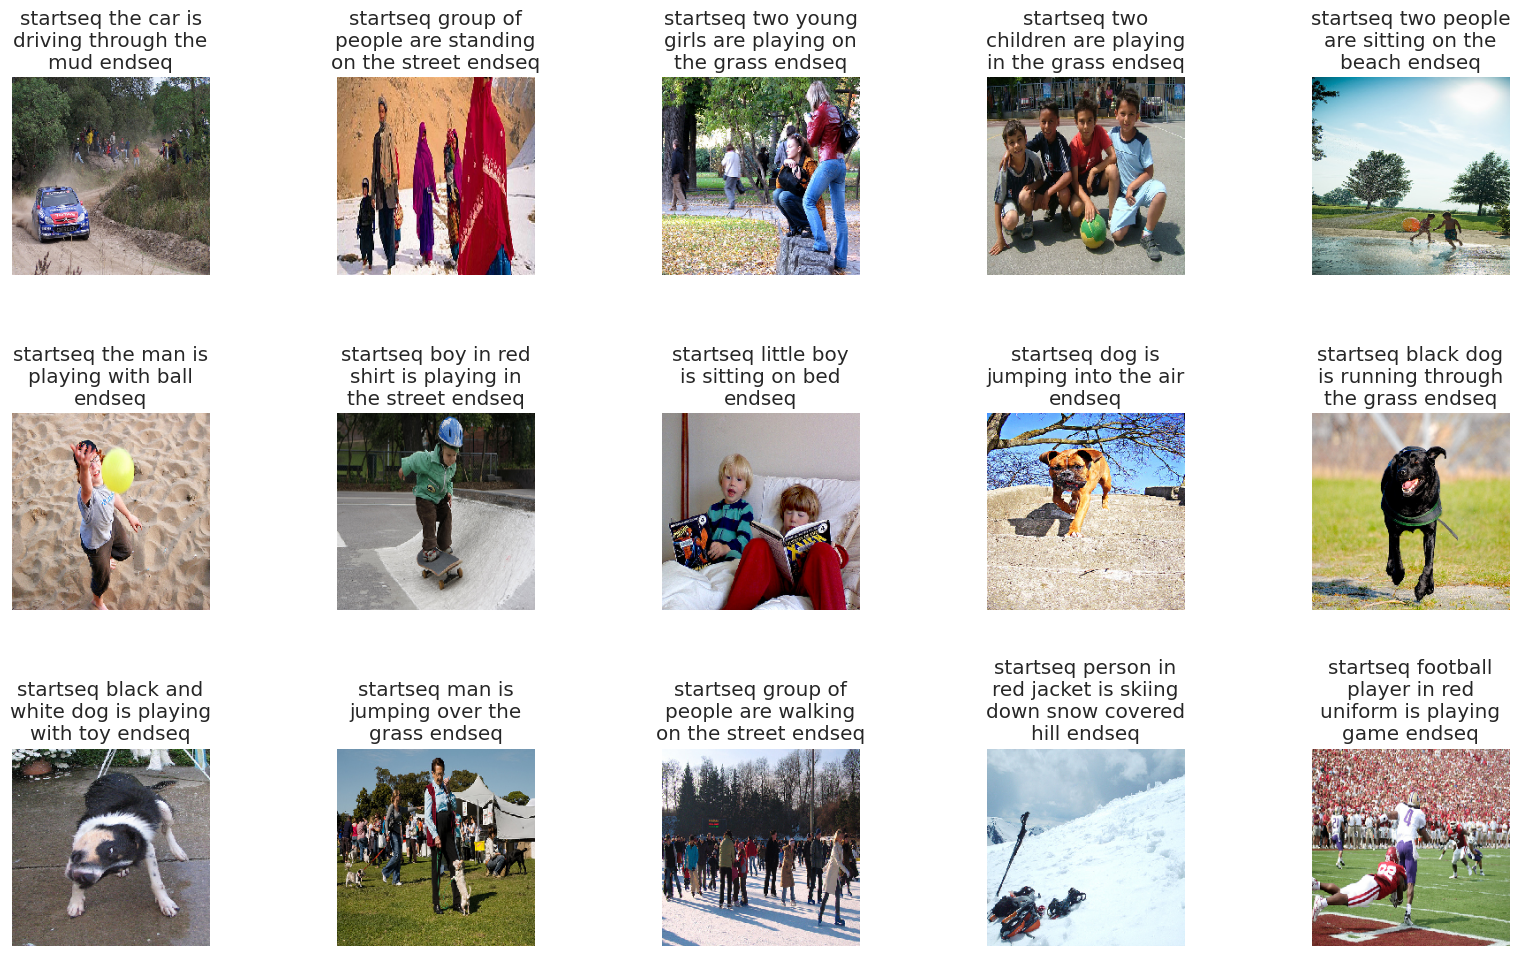

In [72]:
display_images(samples)

<p style='font-size: 18px'><strong>Conclusion: </strong>This may not be the best performing model, but the objective of this kernel is to give a gist of how Image Captioning problems can be approached. In the future work of this kernel <strong>Attention model</strong> training and <strong>BLEU Score</strong> assessment will be performed.</p>

In [73]:
import torch

def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'num_layers':num_layers,
        'embed_size':embed_size,
        'vocab_size':len(train_dataset.vocab),
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'model_state.pth')

In [74]:
model_name

'model2.h5'

In [76]:
history

In [77]:
torch.save(caption_model, 'model2.pth')

In [79]:
checkpoint = torch.load("./model2.pth")
# model.load_state_dict(checkpoint["state_dict"])

2023-05-14 12:22:07.201084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 12:22:07.203041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 12:22:07.204202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [83]:
checkpoint

In [84]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(checkpoint, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 22ms/step


2023-05-14 12:24:16.252661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 12:24:16.254103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 12:24:16.255203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 20ms/step


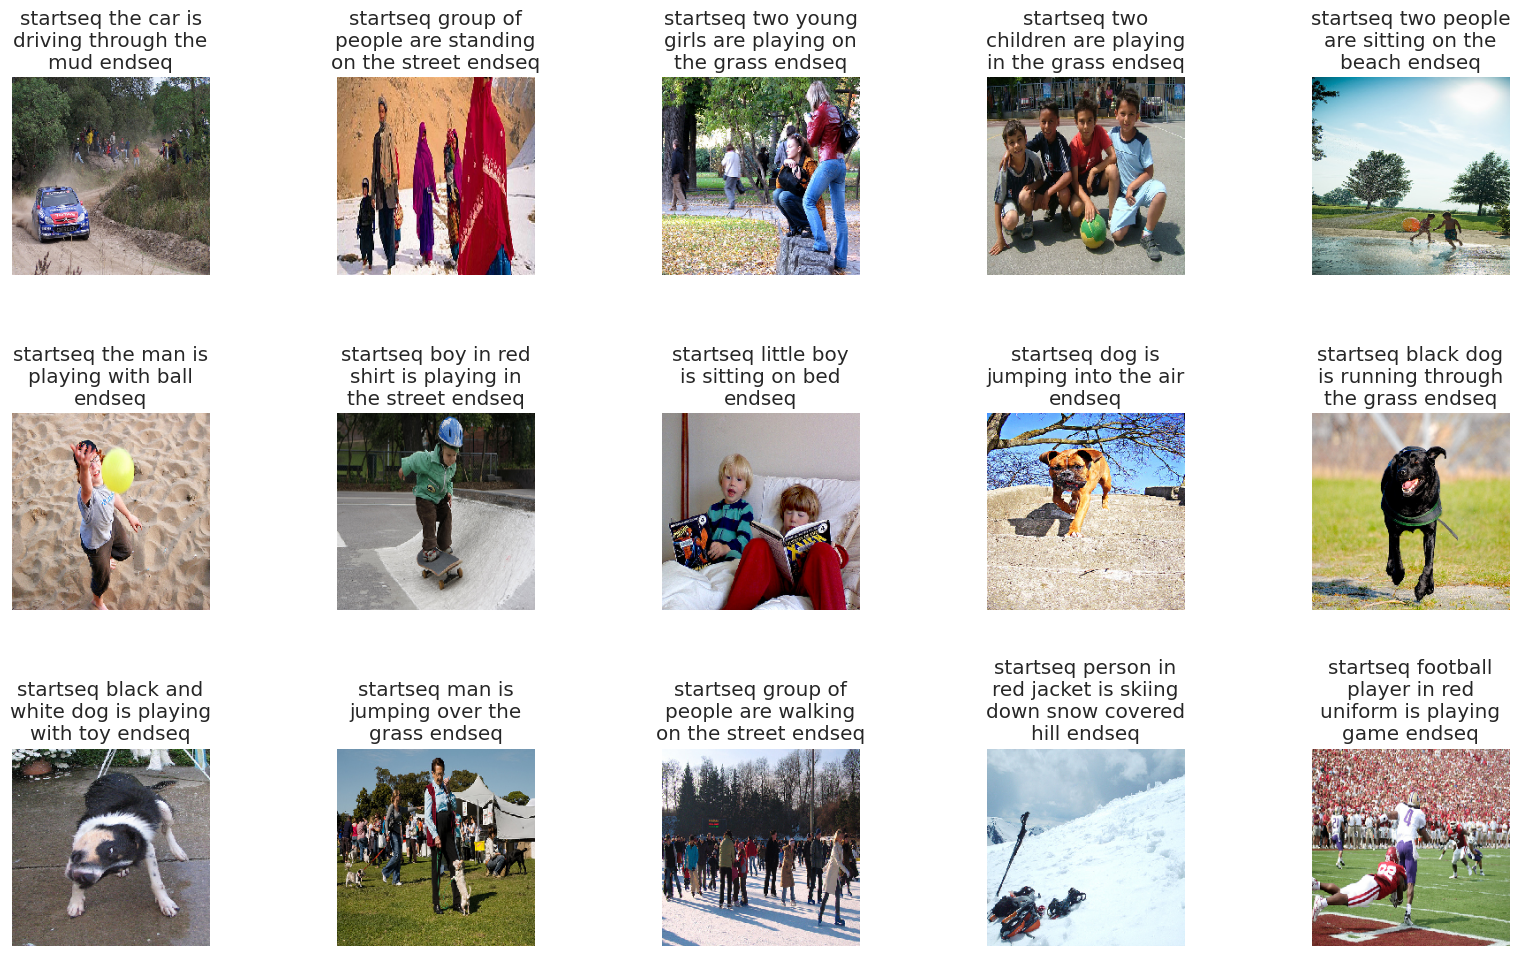

In [85]:
display_images(samples)


In [132]:
img_test = test_image_names[91]

In [133]:
feature_tests = {}
img_test_fe = load_img(os.path.join(image_path,img_test),target_size=(img_size,img_size))
img_test_fe = img_to_array(img_test_fe)
img_test_fe = img_test_fe/255.
img_test_fe = np.expand_dims(img_test_fe,axis=0)
feature_test = fe.predict(img_test_fe, verbose=0)
feature_tests[img_test] = feature_test

In [134]:
feature_tests

{'2374652725_32f90fa15c.jpg': array([[9.0204296e-05, 9.0546336e-04, 2.1594949e-03, ..., 4.6612944e-02,
         9.3247521e-01, 4.1538709e-01]], dtype=float32)}

In [157]:
img = load_img(os.path.join(image_path,img_test),target_size=(224,224))
img = img_to_array(img)
img = img/255.

caption = predict_caption(checkpoint, img_test, tokenizer, max_length, feature_tests)
# samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 27ms/step


startseq two dogs play in the snow endseq


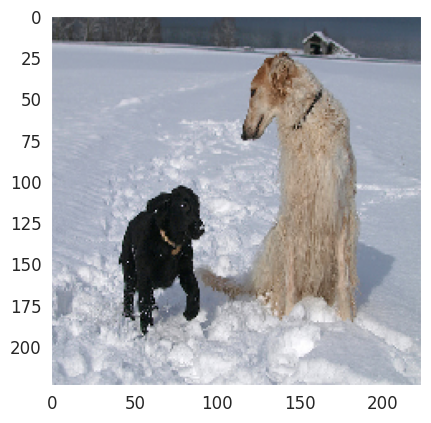

In [158]:
plt.imshow(img)
print(caption)

In [139]:
lemma_desc_list  = open('./Flickr8K/Flickr8k_text/Flickr8k.token.txt','r').read().splitlines()

In [141]:
import string

table = str.maketrans('', '', string.punctuation) # removes all punctuation marks from a sentence.
def preprocess_text(text):
    text = text.lower()
    text = text.split()
    text = [w.translate(table) for w in text]

    # remove tokens with numbers in them
    text = [word for word in text if word.isalpha()]
    # store as string
    
    return ' '.join(text)

In [142]:
lemmatized_text_desc = {}
for i in lemma_desc_list:
    image_name = i.split('\t')[0]
    image_name = image_name.split('#')[0]
    text = i.split('\t')[1]
    text = preprocess_text(text)
    if image_name in lemmatized_text_desc:
        lemmatized_text_desc[image_name].append(text)
    else:
        lemmatized_text_desc[image_name] = [text]

In [143]:
image_name_list = list(lemmatized_text_desc.keys())

In [144]:
for image_name in image_name_list:
    for i in range(len(lemmatized_text_desc[image_name])):
        lemmatized_text_desc[image_name][i] = lemmatized_text_desc[image_name][i]

In [146]:
test_text = {}

for i in test_image_names:
    test_text[i] = lemmatized_text_desc[i]

In [148]:
def remove_seq(test_captions):
    for i in range(len(test_captions)):
        text = test_captions[i]
        word_list = text.split()
        word_list = word_list[1:-1]
        test_captions[i] = ' '.join(word_list)
    return test_captions

In [173]:
import random
from nltk.translate.bleu_score import sentence_bleu


def evaluate_model_greedy(image_list):
    scores = []
    predictions = []
    feature_tests = {}

    # image_list = random.sample(image_list, 100)
    for image_name in tqdm(image_list):    
        img = load_img(os.path.join(image_path,image_name),target_size=(224,224))
        img = img_to_array(img)
        img = img/255.
        img_test = img.copy()
        img_test = np.expand_dims(img_test,axis=0)
        pred = fe.predict(img_test, verbose = 1)
        # print(pred)
        feature_tests[image_name] = pred
        
        # prediction = greedySearch(pred)
        
        prediction = predict_caption(checkpoint, image_name, tokenizer, max_length, feature_tests)
        prediction = prediction[1:-1]
        predictions.append(prediction)


        reference = test_text[image_name].copy()
        # reference = remove_seq(reference)

        score = sentence_bleu(reference, prediction)
        scores.append(score)
    return scores,predictions

In [174]:
g_scores,g_predictions = evaluate_model_greedy(test_image_names)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/1000 [00:00<09:41,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/1000 [00:01<09:28,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 3/1000 [00:01<09:30,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 4/1000 [00:02<09:36,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 5/1000 [00:03<11:49,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 6/1000 [00:03<11:02,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 7/1000 [00:04<11:31,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 8/1000 [00:05<10:56,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 9/1000 [00:05<10:44,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 10/1000 [00:06<09:55,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 11/1000 [00:07<10:45,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 12/1000 [00:08<12:47,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 13/1000 [00:08<12:14,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 14/1000 [00:09<12:11,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 15/1000 [00:10<12:29,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 16/1000 [00:10<11:52,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 17/1000 [00:11<10:53,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 18/1000 [00:11<09:38,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 19/1000 [00:12<09:32,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 20/1000 [00:13<11:00,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 21/1000 [00:14<11:10,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 22/1000 [00:14<10:26,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 23/1000 [00:15<10:53,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 24/1000 [00:15<10:19,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▎         | 25/1000 [00:16<10:18,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 26/1000 [00:17<11:01,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 27/1000 [00:18<12:24,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 28/1000 [00:18<11:30,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 29/1000 [00:19<10:36,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 30/1000 [00:20<11:47,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 31/1000 [00:21<11:55,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 32/1000 [00:21<10:10,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 33/1000 [00:22<11:03,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 34/1000 [00:22<11:00,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 35/1000 [00:23<10:21,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 36/1000 [00:24<10:08,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 37/1000 [00:24<10:20,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 38/1000 [00:25<09:29,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 39/1000 [00:25<08:40,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 40/1000 [00:26<08:37,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 41/1000 [00:26<09:12,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 42/1000 [00:27<09:45,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 43/1000 [00:28<10:00,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 44/1000 [00:28<09:15,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 45/1000 [00:29<10:24,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 46/1000 [00:30<09:52,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 47/1000 [00:30<10:00,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 48/1000 [00:31<09:21,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 49/1000 [00:31<09:20,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 50/1000 [00:32<08:46,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 51/1000 [00:32<08:26,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 52/1000 [00:33<08:38,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 53/1000 [00:33<08:38,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 54/1000 [00:34<08:14,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 55/1000 [00:34<08:15,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 56/1000 [00:35<08:03,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 57/1000 [00:36<08:56,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 58/1000 [00:36<09:14,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 59/1000 [00:37<09:23,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 60/1000 [00:37<09:31,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 61/1000 [00:38<09:28,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 62/1000 [00:39<09:10,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 63/1000 [00:39<09:05,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 64/1000 [00:40<08:40,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 65/1000 [00:40<09:18,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 66/1000 [00:41<10:05,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 67/1000 [00:42<08:57,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 68/1000 [00:42<08:41,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 69/1000 [00:43<09:27,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 70/1000 [00:43<09:43,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 71/1000 [00:44<09:43,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 72/1000 [00:45<09:24,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 73/1000 [00:45<09:38,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 74/1000 [00:46<09:34,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 75/1000 [00:47<09:55,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 76/1000 [00:47<09:29,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 77/1000 [00:48<08:35,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 78/1000 [00:48<08:40,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 79/1000 [00:49<08:47,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 80/1000 [00:49<08:52,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 81/1000 [00:50<08:24,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 82/1000 [00:50<08:20,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 83/1000 [00:51<09:52,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 84/1000 [00:52<09:54,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 85/1000 [00:52<09:25,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 86/1000 [00:54<11:31,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 87/1000 [00:54<10:43,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 88/1000 [00:55<10:06,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 89/1000 [00:55<10:04,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 90/1000 [00:56<09:47,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 91/1000 [00:56<09:20,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 92/1000 [00:57<09:18,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 93/1000 [00:58<09:46,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 94/1000 [00:58<09:28,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 95/1000 [00:59<09:57,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 96/1000 [01:00<09:53,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 97/1000 [01:00<09:01,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 98/1000 [01:01<10:20,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 99/1000 [01:02<09:58,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 100/1000 [01:02<09:47,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 101/1000 [01:03<09:52,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 102/1000 [01:03<08:35,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 103/1000 [01:04<08:25,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 104/1000 [01:05<08:28,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 105/1000 [01:05<08:23,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 106/1000 [01:06<08:11,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 107/1000 [01:06<09:07,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 108/1000 [01:07<10:02,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 109/1000 [01:08<09:34,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 110/1000 [01:08<09:04,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 111/1000 [01:09<09:41,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 112/1000 [01:10<10:42,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 113/1000 [01:11<10:46,  1.37it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 114/1000 [01:12<11:18,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 115/1000 [01:12<10:36,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 116/1000 [01:13<10:13,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 117/1000 [01:13<09:22,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 118/1000 [01:14<09:04,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 119/1000 [01:14<08:52,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 120/1000 [01:15<08:59,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 121/1000 [01:16<09:14,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 122/1000 [01:16<08:51,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 123/1000 [01:17<08:24,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 124/1000 [01:17<08:12,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 125/1000 [01:18<08:19,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 126/1000 [01:18<07:50,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 127/1000 [01:19<08:02,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 128/1000 [01:20<08:08,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 129/1000 [01:20<07:47,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 130/1000 [01:21<08:01,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 131/1000 [01:21<08:00,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 132/1000 [01:22<07:54,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 133/1000 [01:22<08:26,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 134/1000 [01:23<08:32,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 135/1000 [01:24<09:29,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 136/1000 [01:24<08:55,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 137/1000 [01:25<08:38,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 138/1000 [01:25<08:32,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 139/1000 [01:26<09:51,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 140/1000 [01:27<09:09,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 141/1000 [01:28<09:45,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 142/1000 [01:28<09:33,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 143/1000 [01:29<09:16,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 144/1000 [01:30<09:34,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 145/1000 [01:30<08:51,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 146/1000 [01:31<09:22,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 147/1000 [01:32<09:21,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 148/1000 [01:32<09:55,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 149/1000 [01:33<09:24,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 150/1000 [01:34<10:27,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 151/1000 [01:34<09:28,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 152/1000 [01:35<10:28,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 153/1000 [01:36<09:02,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 154/1000 [01:36<08:45,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 155/1000 [01:37<08:47,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 156/1000 [01:38<09:23,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 157/1000 [01:38<09:07,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 158/1000 [01:39<10:36,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 159/1000 [01:40<09:50,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 160/1000 [01:40<08:58,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 161/1000 [01:41<10:22,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 162/1000 [01:42<09:40,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 163/1000 [01:42<09:06,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 164/1000 [01:43<08:46,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 165/1000 [01:44<08:22,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 166/1000 [01:44<08:03,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 167/1000 [01:45<08:02,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 168/1000 [01:45<08:00,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 169/1000 [01:46<07:57,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 170/1000 [01:46<08:31,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 171/1000 [01:47<08:11,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 172/1000 [01:48<11:20,  1.22it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 173/1000 [01:49<11:40,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 174/1000 [01:50<11:01,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 175/1000 [01:51<10:36,  1.30it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 176/1000 [01:52<11:49,  1.16it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 177/1000 [01:53<11:38,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 178/1000 [01:53<10:25,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 179/1000 [01:54<09:53,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 180/1000 [01:55<09:59,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 181/1000 [01:55<10:00,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 182/1000 [01:56<09:45,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 183/1000 [01:57<09:34,  1.42it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 184/1000 [01:57<09:41,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 185/1000 [01:58<09:25,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 186/1000 [01:59<09:51,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 187/1000 [02:00<09:47,  1.38it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 188/1000 [02:00<09:16,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 189/1000 [02:01<09:19,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 190/1000 [02:01<09:08,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 191/1000 [02:03<12:14,  1.10it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 192/1000 [02:04<12:10,  1.11it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 193/1000 [02:04<10:46,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 194/1000 [02:05<09:48,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 195/1000 [02:06<09:51,  1.36it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 196/1000 [02:06<09:53,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 197/1000 [02:07<10:09,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 198/1000 [02:08<09:45,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 199/1000 [02:09<09:42,  1.38it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 200/1000 [02:09<08:47,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 201/1000 [02:10<08:55,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 202/1000 [02:11<09:45,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 203/1000 [02:11<09:15,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 204/1000 [02:12<08:04,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 205/1000 [02:13<09:19,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 206/1000 [02:13<08:32,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 207/1000 [02:14<08:22,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 208/1000 [02:14<08:11,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 209/1000 [02:15<08:30,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 210/1000 [02:15<07:32,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 211/1000 [02:16<08:16,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 212/1000 [02:17<09:18,  1.41it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 213/1000 [02:18<09:04,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 214/1000 [02:19<09:23,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 215/1000 [02:19<08:50,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 216/1000 [02:20<10:10,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 217/1000 [02:21<09:24,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 218/1000 [02:21<09:12,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 219/1000 [02:22<08:36,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 220/1000 [02:22<08:05,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 221/1000 [02:23<07:59,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 222/1000 [02:24<08:03,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 223/1000 [02:24<08:24,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 224/1000 [02:25<07:52,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▎       | 225/1000 [02:25<07:15,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 226/1000 [02:26<07:10,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 227/1000 [02:27<07:13,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 228/1000 [02:27<07:34,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 229/1000 [02:28<07:16,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 230/1000 [02:28<08:09,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 231/1000 [02:29<07:50,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 232/1000 [02:30<07:38,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 233/1000 [02:30<07:21,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 234/1000 [02:30<06:37,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 235/1000 [02:31<07:25,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 236/1000 [02:32<07:26,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 237/1000 [02:32<07:44,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 238/1000 [02:33<07:06,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 239/1000 [02:33<06:35,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 240/1000 [02:34<07:18,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 241/1000 [02:35<08:21,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 242/1000 [02:36<08:16,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 243/1000 [02:36<08:29,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 244/1000 [02:37<08:02,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 245/1000 [02:37<07:51,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 246/1000 [02:38<07:06,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 247/1000 [02:38<07:06,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 248/1000 [02:39<06:57,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 249/1000 [02:39<06:35,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 250/1000 [02:40<06:41,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 251/1000 [02:40<06:17,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 252/1000 [02:41<06:07,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 253/1000 [02:41<06:23,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 254/1000 [02:42<07:10,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 255/1000 [02:43<06:59,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 256/1000 [02:43<06:49,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 257/1000 [02:44<06:42,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 258/1000 [02:44<06:16,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 259/1000 [02:45<06:05,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 260/1000 [02:45<05:59,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 261/1000 [02:46<06:21,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 262/1000 [02:46<06:21,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 263/1000 [02:47<06:25,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 264/1000 [02:47<06:51,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 265/1000 [02:48<06:39,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 266/1000 [02:48<06:15,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 267/1000 [02:49<06:11,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 268/1000 [02:50<07:38,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 269/1000 [02:50<07:17,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 270/1000 [02:51<06:44,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 271/1000 [02:51<06:48,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 272/1000 [02:52<06:43,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 273/1000 [02:52<06:17,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 274/1000 [02:53<06:12,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 275/1000 [02:53<06:00,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 276/1000 [02:54<05:49,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 277/1000 [02:54<05:25,  2.22it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 278/1000 [02:54<05:24,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 279/1000 [02:55<05:26,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 280/1000 [02:56<07:09,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 281/1000 [02:56<07:05,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 282/1000 [02:57<06:48,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 283/1000 [02:57<06:20,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 284/1000 [02:58<06:30,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 285/1000 [02:59<07:07,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 286/1000 [02:59<07:03,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 287/1000 [03:00<06:25,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 288/1000 [03:00<05:56,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 289/1000 [03:01<05:41,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 290/1000 [03:01<05:32,  2.13it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 291/1000 [03:01<05:17,  2.23it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 292/1000 [03:02<05:17,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 293/1000 [03:03<06:27,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 294/1000 [03:03<06:27,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 295/1000 [03:04<06:05,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 296/1000 [03:04<05:31,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 297/1000 [03:04<05:28,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 298/1000 [03:05<05:28,  2.14it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 299/1000 [03:05<05:51,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 300/1000 [03:06<05:50,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 301/1000 [03:07<07:00,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 302/1000 [03:07<06:44,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 303/1000 [03:08<07:07,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 304/1000 [03:09<06:42,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 305/1000 [03:09<06:52,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 306/1000 [03:10<06:39,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 307/1000 [03:10<06:34,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 308/1000 [03:11<06:28,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 309/1000 [03:11<06:11,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 310/1000 [03:12<05:26,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 311/1000 [03:12<05:35,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 312/1000 [03:13<05:17,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 313/1000 [03:13<05:27,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 314/1000 [03:14<05:57,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 315/1000 [03:14<06:03,  1.89it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 316/1000 [03:15<06:53,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 317/1000 [03:16<07:11,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 318/1000 [03:16<06:57,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 319/1000 [03:17<07:43,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 320/1000 [03:17<06:42,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 321/1000 [03:18<06:54,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 322/1000 [03:19<06:54,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 323/1000 [03:19<06:51,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 324/1000 [03:20<07:26,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▎      | 325/1000 [03:21<06:41,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 326/1000 [03:21<06:38,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 327/1000 [03:22<07:20,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 328/1000 [03:23<07:31,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 329/1000 [03:23<06:56,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 330/1000 [03:24<06:31,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 331/1000 [03:24<06:21,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 332/1000 [03:25<05:54,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 333/1000 [03:25<05:56,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 334/1000 [03:26<06:30,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 335/1000 [03:27<06:36,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 336/1000 [03:27<06:43,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 337/1000 [03:28<06:27,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 338/1000 [03:28<06:06,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 339/1000 [03:29<06:04,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 340/1000 [03:29<05:59,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 341/1000 [03:30<05:42,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 342/1000 [03:30<05:48,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 343/1000 [03:31<06:14,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 344/1000 [03:31<05:53,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 345/1000 [03:32<06:32,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 346/1000 [03:33<06:01,  1.81it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 347/1000 [03:33<06:22,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 348/1000 [03:34<06:32,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 349/1000 [03:35<07:20,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 350/1000 [03:35<07:07,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 351/1000 [03:36<06:51,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 352/1000 [03:36<06:26,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 353/1000 [03:37<05:53,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 354/1000 [03:37<05:47,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 355/1000 [03:38<05:54,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 356/1000 [03:38<05:31,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 357/1000 [03:39<05:15,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 358/1000 [03:40<06:04,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 359/1000 [03:40<06:00,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 360/1000 [03:41<05:57,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 361/1000 [03:41<06:09,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 362/1000 [03:42<05:58,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 363/1000 [03:42<06:00,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 364/1000 [03:43<06:04,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 365/1000 [03:43<05:42,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 366/1000 [03:44<05:18,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 367/1000 [03:44<05:06,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 368/1000 [03:45<05:00,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 369/1000 [03:45<04:41,  2.24it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 370/1000 [03:46<04:53,  2.14it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 371/1000 [03:46<05:00,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 372/1000 [03:47<05:09,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 373/1000 [03:47<05:01,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 374/1000 [03:48<04:55,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 375/1000 [03:48<05:06,  2.04it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 376/1000 [03:49<04:53,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 377/1000 [03:49<04:49,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 378/1000 [03:49<04:46,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 379/1000 [03:50<05:13,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 380/1000 [03:50<05:02,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 381/1000 [03:51<05:45,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 382/1000 [03:52<05:49,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 383/1000 [03:52<05:32,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 384/1000 [03:53<06:13,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 385/1000 [03:54<06:10,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 386/1000 [03:54<05:51,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 387/1000 [03:55<05:21,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 388/1000 [03:55<05:37,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 389/1000 [03:56<05:26,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 390/1000 [03:56<05:50,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 391/1000 [03:57<05:30,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 392/1000 [03:57<05:49,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 393/1000 [03:58<05:10,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 394/1000 [03:58<05:07,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 395/1000 [03:59<04:50,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 396/1000 [03:59<04:52,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 397/1000 [04:00<04:48,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 398/1000 [04:00<04:49,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 399/1000 [04:01<04:43,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 400/1000 [04:01<04:36,  2.17it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 401/1000 [04:02<04:51,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 402/1000 [04:02<05:39,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 403/1000 [04:03<05:27,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 404/1000 [04:03<05:12,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 405/1000 [04:04<05:00,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 406/1000 [04:04<04:42,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 407/1000 [04:05<04:37,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 408/1000 [04:05<04:29,  2.19it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 409/1000 [04:06<04:34,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 410/1000 [04:06<04:58,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 411/1000 [04:07<04:52,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 412/1000 [04:08<08:03,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 413/1000 [04:09<07:19,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 414/1000 [04:09<06:23,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 415/1000 [04:11<09:05,  1.07it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 416/1000 [04:11<07:33,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 417/1000 [04:12<06:40,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 418/1000 [04:12<05:58,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 419/1000 [04:13<05:18,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 420/1000 [04:13<05:23,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 421/1000 [04:14<04:55,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 422/1000 [04:14<04:50,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 423/1000 [04:14<04:43,  2.03it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 424/1000 [04:15<04:31,  2.12it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▎     | 425/1000 [04:15<04:21,  2.20it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 426/1000 [04:16<04:28,  2.14it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 427/1000 [04:16<04:16,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 428/1000 [04:17<04:51,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 429/1000 [04:17<04:48,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 430/1000 [04:18<04:40,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 431/1000 [04:18<04:26,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 432/1000 [04:19<04:27,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 433/1000 [04:19<04:18,  2.20it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 434/1000 [04:20<04:36,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 435/1000 [04:20<04:38,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 436/1000 [04:21<04:34,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 437/1000 [04:21<04:40,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 438/1000 [04:22<04:26,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 439/1000 [04:22<04:21,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 440/1000 [04:23<04:31,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 441/1000 [04:23<04:37,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 442/1000 [04:24<04:27,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 443/1000 [04:24<04:38,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 444/1000 [04:25<04:37,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 445/1000 [04:25<04:53,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 446/1000 [04:26<05:02,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 447/1000 [04:26<04:40,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 448/1000 [04:27<04:17,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 449/1000 [04:27<04:15,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 450/1000 [04:28<04:33,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 451/1000 [04:28<04:32,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 452/1000 [04:29<04:22,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 453/1000 [04:29<03:51,  2.36it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 454/1000 [04:29<04:23,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 455/1000 [04:30<04:19,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 456/1000 [04:30<04:02,  2.24it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 457/1000 [04:31<04:38,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 458/1000 [04:32<04:46,  1.89it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 459/1000 [04:32<04:35,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 460/1000 [04:32<04:27,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 461/1000 [04:33<04:20,  2.07it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 462/1000 [04:33<04:09,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 463/1000 [04:34<04:13,  2.12it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 464/1000 [04:34<04:15,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 465/1000 [04:35<04:30,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 466/1000 [04:35<04:29,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 467/1000 [04:36<04:14,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 468/1000 [04:36<04:30,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 469/1000 [04:39<09:21,  1.06s/it]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 470/1000 [04:39<07:58,  1.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 471/1000 [04:40<06:41,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 472/1000 [04:40<06:00,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 473/1000 [04:41<05:30,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 474/1000 [04:41<05:11,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 475/1000 [04:42<06:42,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 476/1000 [04:43<06:03,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 477/1000 [04:43<05:37,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 478/1000 [04:44<05:00,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 479/1000 [04:45<05:19,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 480/1000 [04:45<05:28,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 481/1000 [04:46<04:56,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 482/1000 [04:46<04:54,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 483/1000 [04:47<04:45,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 484/1000 [04:47<04:39,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 485/1000 [04:48<04:24,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 486/1000 [04:48<04:26,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 487/1000 [04:49<04:40,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 488/1000 [04:49<04:28,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 489/1000 [04:50<04:26,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 490/1000 [04:51<04:54,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 491/1000 [04:51<04:30,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 492/1000 [04:51<04:10,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 493/1000 [04:52<04:30,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 494/1000 [04:53<04:36,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 495/1000 [04:53<04:25,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 496/1000 [04:53<04:16,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 497/1000 [04:54<04:55,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 498/1000 [04:55<04:39,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 499/1000 [04:55<05:05,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 500/1000 [04:56<04:28,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 501/1000 [04:56<04:15,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 502/1000 [04:57<04:00,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 503/1000 [04:57<03:48,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 504/1000 [04:58<03:44,  2.21it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 505/1000 [04:58<04:16,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 506/1000 [04:59<04:06,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 507/1000 [04:59<04:06,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 508/1000 [05:00<04:09,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 509/1000 [05:00<03:43,  2.20it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 510/1000 [05:00<03:30,  2.33it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 511/1000 [05:01<03:42,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 512/1000 [05:01<03:41,  2.20it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 513/1000 [05:02<03:52,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 514/1000 [05:02<03:34,  2.26it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 515/1000 [05:03<03:51,  2.10it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 516/1000 [05:03<03:49,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 517/1000 [05:04<03:50,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 518/1000 [05:04<03:52,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 519/1000 [05:05<03:50,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 520/1000 [05:05<03:45,  2.13it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 521/1000 [05:06<04:35,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 522/1000 [05:06<04:18,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 523/1000 [05:07<04:12,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 524/1000 [05:08<04:14,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 525/1000 [05:08<04:26,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 526/1000 [05:09<04:11,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 527/1000 [05:09<04:17,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 528/1000 [05:10<04:13,  1.86it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 529/1000 [05:10<03:49,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 530/1000 [05:11<03:43,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 531/1000 [05:11<03:27,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 532/1000 [05:12<04:15,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 533/1000 [05:12<04:15,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 534/1000 [05:13<04:07,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 535/1000 [05:13<03:58,  1.95it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 536/1000 [05:14<03:49,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 537/1000 [05:14<03:37,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 538/1000 [05:15<03:34,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 539/1000 [05:15<03:43,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 540/1000 [05:16<03:49,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 541/1000 [05:16<03:52,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 542/1000 [05:17<03:52,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 543/1000 [05:17<04:25,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 544/1000 [05:18<03:55,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 545/1000 [05:18<03:34,  2.12it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 546/1000 [05:19<03:37,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 547/1000 [05:19<03:44,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 548/1000 [05:20<03:42,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 549/1000 [05:20<03:37,  2.07it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 550/1000 [05:21<04:00,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 551/1000 [05:21<03:53,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 552/1000 [05:22<03:59,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 553/1000 [05:22<03:53,  1.92it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 554/1000 [05:23<03:39,  2.03it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 555/1000 [05:24<06:08,  1.21it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 556/1000 [05:25<05:39,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 557/1000 [05:25<04:51,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 558/1000 [05:26<04:24,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 559/1000 [05:26<04:09,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 560/1000 [05:27<03:46,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 561/1000 [05:27<03:42,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 562/1000 [05:28<03:34,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 563/1000 [05:28<03:23,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 564/1000 [05:29<03:27,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 565/1000 [05:29<03:22,  2.15it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 566/1000 [05:29<03:19,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 567/1000 [05:30<03:43,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 568/1000 [05:30<03:27,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 569/1000 [05:31<03:35,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 570/1000 [05:32<03:57,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 571/1000 [05:32<04:06,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 572/1000 [05:33<04:03,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 573/1000 [05:33<03:47,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 574/1000 [05:34<03:37,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 575/1000 [05:34<03:36,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 576/1000 [05:35<03:17,  2.15it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 577/1000 [05:35<03:42,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 578/1000 [05:36<03:26,  2.04it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 579/1000 [05:36<03:37,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 580/1000 [05:37<03:38,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 581/1000 [05:37<03:34,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 582/1000 [05:38<03:24,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 583/1000 [05:38<03:22,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 584/1000 [05:39<03:14,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 585/1000 [05:39<03:35,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 586/1000 [05:40<03:25,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 587/1000 [05:40<03:16,  2.10it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 588/1000 [05:41<03:47,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 589/1000 [05:41<03:25,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 590/1000 [05:42<03:19,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 591/1000 [05:42<03:14,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 592/1000 [05:43<03:12,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 593/1000 [05:43<03:09,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 594/1000 [05:43<02:53,  2.34it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 595/1000 [05:44<03:13,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 596/1000 [05:45<03:24,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 597/1000 [05:45<03:19,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 598/1000 [05:46<03:23,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 599/1000 [05:46<03:04,  2.18it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 600/1000 [05:46<02:53,  2.31it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 601/1000 [05:47<02:49,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 602/1000 [05:47<03:03,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 603/1000 [05:48<03:02,  2.18it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 604/1000 [05:48<03:36,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 605/1000 [05:49<03:30,  1.88it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 606/1000 [05:49<03:16,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 607/1000 [05:50<03:12,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 608/1000 [05:50<03:28,  1.88it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 609/1000 [05:51<03:36,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 610/1000 [05:52<03:28,  1.87it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 611/1000 [05:52<03:16,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 612/1000 [05:52<03:05,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 613/1000 [05:53<03:01,  2.13it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 614/1000 [05:53<03:04,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 615/1000 [05:54<03:01,  2.12it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 616/1000 [05:54<03:18,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 617/1000 [05:55<03:15,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 618/1000 [05:55<03:03,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 619/1000 [05:56<03:27,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 620/1000 [05:56<03:15,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 621/1000 [05:57<02:58,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 622/1000 [05:57<02:45,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 623/1000 [05:58<02:51,  2.19it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 624/1000 [05:58<02:36,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 625/1000 [05:58<02:36,  2.40it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 626/1000 [05:59<02:58,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 627/1000 [06:00<03:09,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 628/1000 [06:00<03:20,  1.86it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 629/1000 [06:01<03:18,  1.87it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 630/1000 [06:01<03:26,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 631/1000 [06:02<03:03,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 632/1000 [06:02<03:02,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 633/1000 [06:03<02:56,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 634/1000 [06:03<02:52,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 635/1000 [06:04<02:49,  2.15it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 636/1000 [06:04<02:52,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 637/1000 [06:05<02:49,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 638/1000 [06:05<02:45,  2.19it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 639/1000 [06:05<02:40,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 640/1000 [06:06<02:54,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 641/1000 [06:06<02:50,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 642/1000 [06:07<02:45,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 643/1000 [06:07<02:47,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 644/1000 [06:08<02:48,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 645/1000 [06:08<03:01,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 646/1000 [06:09<02:55,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 647/1000 [06:09<02:52,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 648/1000 [06:10<03:08,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 649/1000 [06:10<02:57,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 650/1000 [06:11<02:54,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 651/1000 [06:12<03:31,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 652/1000 [06:12<03:14,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 653/1000 [06:13<03:07,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 654/1000 [06:13<02:58,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 655/1000 [06:14<02:55,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 656/1000 [06:14<02:50,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 657/1000 [06:15<02:47,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 658/1000 [06:15<02:38,  2.16it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 659/1000 [06:16<02:48,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 660/1000 [06:16<02:34,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 661/1000 [06:16<02:29,  2.27it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 662/1000 [06:17<02:28,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 663/1000 [06:17<02:39,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 664/1000 [06:18<02:55,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 665/1000 [06:19<02:59,  1.87it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 666/1000 [06:19<02:42,  2.06it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 667/1000 [06:19<02:28,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 668/1000 [06:20<02:16,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 669/1000 [06:20<02:20,  2.35it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 670/1000 [06:20<02:18,  2.39it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 671/1000 [06:21<02:28,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 672/1000 [06:21<02:26,  2.23it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 673/1000 [06:22<02:26,  2.24it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 674/1000 [06:22<02:26,  2.22it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 675/1000 [06:23<02:28,  2.20it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 676/1000 [06:23<02:24,  2.25it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 677/1000 [06:24<02:16,  2.36it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 678/1000 [06:24<02:48,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 679/1000 [06:25<02:40,  2.00it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 680/1000 [06:25<02:35,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 681/1000 [06:26<02:32,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 682/1000 [06:26<02:25,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 683/1000 [06:27<02:34,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 684/1000 [06:27<02:46,  1.90it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 685/1000 [06:28<02:55,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 686/1000 [06:28<02:44,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 687/1000 [06:29<02:33,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 688/1000 [06:29<02:26,  2.12it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 689/1000 [06:30<02:21,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 690/1000 [06:30<02:25,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 691/1000 [06:31<02:24,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 692/1000 [06:31<02:31,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 693/1000 [06:32<02:25,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 694/1000 [06:32<02:19,  2.19it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 695/1000 [06:32<02:16,  2.24it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 696/1000 [06:33<02:35,  1.96it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 697/1000 [06:34<02:27,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 698/1000 [06:34<02:23,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 699/1000 [06:34<02:16,  2.20it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 700/1000 [06:35<02:17,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 701/1000 [06:35<02:17,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 702/1000 [06:36<02:19,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 703/1000 [06:36<02:32,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 704/1000 [06:37<02:19,  2.12it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 705/1000 [06:37<02:18,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 706/1000 [06:38<02:13,  2.20it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 707/1000 [06:38<02:07,  2.29it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 708/1000 [06:39<02:14,  2.17it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 709/1000 [06:39<02:35,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 710/1000 [06:40<02:42,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 711/1000 [06:40<02:17,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 712/1000 [06:41<02:23,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 713/1000 [06:41<02:19,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 714/1000 [06:42<02:28,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 715/1000 [06:42<02:15,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 716/1000 [06:43<02:09,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 717/1000 [06:43<02:20,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 718/1000 [06:44<02:17,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 719/1000 [06:44<02:12,  2.12it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 720/1000 [06:45<02:22,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 721/1000 [06:45<02:14,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 722/1000 [06:46<02:22,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 723/1000 [06:46<02:16,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 724/1000 [06:47<02:13,  2.07it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▎  | 725/1000 [06:47<02:12,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 726/1000 [06:48<02:16,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 727/1000 [06:48<02:21,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 728/1000 [06:49<02:15,  2.00it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 729/1000 [06:49<02:13,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 730/1000 [06:50<02:16,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 731/1000 [06:50<02:14,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 732/1000 [06:51<02:15,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 733/1000 [06:51<02:13,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 734/1000 [06:52<02:09,  2.06it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 735/1000 [06:52<02:15,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 736/1000 [06:53<02:20,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 737/1000 [06:53<02:13,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 738/1000 [06:54<02:09,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 739/1000 [06:54<02:11,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 740/1000 [06:55<02:13,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 741/1000 [06:55<02:17,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 742/1000 [06:56<02:28,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 743/1000 [06:56<02:12,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 744/1000 [06:57<02:05,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 745/1000 [06:57<02:08,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 746/1000 [06:58<01:51,  2.28it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 747/1000 [06:58<01:51,  2.28it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 748/1000 [06:59<02:06,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 749/1000 [06:59<02:11,  1.91it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 750/1000 [07:00<02:09,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 751/1000 [07:00<02:04,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 752/1000 [07:01<02:00,  2.07it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 753/1000 [07:01<02:13,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 754/1000 [07:02<02:04,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 755/1000 [07:02<02:16,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 756/1000 [07:03<02:08,  1.89it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 757/1000 [07:03<02:03,  1.97it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 758/1000 [07:04<01:59,  2.03it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 759/1000 [07:04<01:54,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 760/1000 [07:05<01:55,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 761/1000 [07:05<02:01,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 762/1000 [07:06<01:54,  2.07it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 763/1000 [07:06<01:45,  2.25it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 764/1000 [07:07<01:55,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 765/1000 [07:07<01:59,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 766/1000 [07:08<01:50,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 767/1000 [07:09<02:32,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 768/1000 [07:09<02:21,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 769/1000 [07:10<02:24,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 770/1000 [07:10<02:12,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 771/1000 [07:11<02:10,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 772/1000 [07:12<02:15,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 773/1000 [07:12<02:10,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 774/1000 [07:13<02:32,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 775/1000 [07:13<02:22,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 776/1000 [07:14<02:06,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 777/1000 [07:15<02:10,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 778/1000 [07:15<02:02,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 779/1000 [07:15<01:50,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 780/1000 [07:16<01:59,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 781/1000 [07:17<02:05,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 782/1000 [07:17<02:02,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 783/1000 [07:18<02:05,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 784/1000 [07:18<02:00,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 785/1000 [07:19<01:57,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 786/1000 [07:19<01:53,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 787/1000 [07:20<01:45,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 788/1000 [07:20<01:53,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 789/1000 [07:21<01:52,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 790/1000 [07:21<01:50,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 791/1000 [07:22<01:51,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 792/1000 [07:22<01:49,  1.91it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 793/1000 [07:23<01:52,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 794/1000 [07:24<01:48,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 795/1000 [07:24<01:45,  1.94it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 796/1000 [07:25<01:44,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 797/1000 [07:25<01:45,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 798/1000 [07:26<01:42,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 799/1000 [07:26<01:51,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 800/1000 [07:27<01:41,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 801/1000 [07:27<01:47,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 802/1000 [07:28<01:47,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 803/1000 [07:28<01:51,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 804/1000 [07:29<01:44,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 805/1000 [07:29<01:39,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 806/1000 [07:30<01:30,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 807/1000 [07:30<01:41,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 808/1000 [07:31<01:37,  1.97it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 809/1000 [07:31<01:33,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 810/1000 [07:32<01:29,  2.13it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 811/1000 [07:32<01:32,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 812/1000 [07:33<01:30,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 813/1000 [07:33<01:33,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 814/1000 [07:34<01:28,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 815/1000 [07:34<01:26,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 816/1000 [07:34<01:22,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 817/1000 [07:35<01:21,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 818/1000 [07:36<01:30,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 819/1000 [07:36<01:28,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 820/1000 [07:37<01:36,  1.87it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 821/1000 [07:37<01:30,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 822/1000 [07:37<01:18,  2.27it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 823/1000 [07:38<01:18,  2.25it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 824/1000 [07:38<01:22,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 825/1000 [07:39<01:19,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 826/1000 [07:39<01:17,  2.24it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 827/1000 [07:40<01:17,  2.22it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 828/1000 [07:40<01:27,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 829/1000 [07:41<01:21,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 830/1000 [07:41<01:20,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 831/1000 [07:42<01:15,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 832/1000 [07:42<01:20,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 833/1000 [07:43<01:18,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 834/1000 [07:43<01:16,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 835/1000 [07:43<01:17,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 836/1000 [07:44<01:14,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 837/1000 [07:44<01:19,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 838/1000 [07:45<01:15,  2.15it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 839/1000 [07:45<01:16,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 840/1000 [07:46<01:15,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 841/1000 [07:46<01:14,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 842/1000 [07:47<01:27,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 843/1000 [07:47<01:20,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 844/1000 [07:48<01:17,  2.00it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 845/1000 [07:48<01:17,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 846/1000 [07:49<01:12,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 847/1000 [07:49<01:12,  2.12it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 848/1000 [07:50<01:08,  2.22it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 849/1000 [07:50<01:07,  2.23it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 850/1000 [07:51<01:07,  2.24it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 851/1000 [07:51<01:07,  2.21it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 852/1000 [07:52<01:16,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 853/1000 [07:52<01:14,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 854/1000 [07:53<01:18,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 855/1000 [07:53<01:14,  1.94it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 856/1000 [07:54<01:13,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 857/1000 [07:54<01:15,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 858/1000 [07:55<01:15,  1.89it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 859/1000 [07:55<01:09,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 860/1000 [07:56<01:07,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 861/1000 [07:56<01:08,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 862/1000 [07:57<01:10,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 863/1000 [07:57<01:08,  2.00it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 864/1000 [07:58<01:04,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 865/1000 [07:58<01:00,  2.25it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 866/1000 [07:59<01:01,  2.18it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 867/1000 [07:59<00:58,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 868/1000 [07:59<00:58,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 869/1000 [08:00<01:02,  2.08it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 870/1000 [08:01<01:02,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 871/1000 [08:01<01:01,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 872/1000 [08:01<00:56,  2.26it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 873/1000 [08:02<00:56,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 874/1000 [08:02<00:54,  2.30it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 875/1000 [08:03<00:52,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 876/1000 [08:03<00:51,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 877/1000 [08:03<00:49,  2.48it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 878/1000 [08:04<00:49,  2.46it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 879/1000 [08:04<00:51,  2.36it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 880/1000 [08:05<00:53,  2.25it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 881/1000 [08:05<00:51,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 882/1000 [08:06<01:00,  1.96it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 883/1000 [08:06<00:58,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 884/1000 [08:07<00:56,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 885/1000 [08:07<00:57,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 886/1000 [08:08<01:01,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 887/1000 [08:08<00:58,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 888/1000 [08:09<00:58,  1.90it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 889/1000 [08:09<00:56,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 890/1000 [08:10<00:59,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 891/1000 [08:11<00:58,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 892/1000 [08:11<00:58,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 893/1000 [08:12<00:56,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 894/1000 [08:12<00:54,  1.94it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 895/1000 [08:13<00:57,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 896/1000 [08:13<00:53,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 897/1000 [08:14<00:51,  2.01it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 898/1000 [08:14<00:45,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 899/1000 [08:15<00:49,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 900/1000 [08:15<00:50,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 901/1000 [08:16<00:49,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 902/1000 [08:16<00:52,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 903/1000 [08:17<00:53,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 904/1000 [08:18<01:23,  1.15it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 905/1000 [08:19<01:11,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 906/1000 [08:19<01:03,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 907/1000 [08:20<00:57,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 908/1000 [08:20<00:52,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 909/1000 [08:21<00:53,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 910/1000 [08:21<00:47,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 911/1000 [08:22<00:44,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 912/1000 [08:22<00:45,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 913/1000 [08:23<00:43,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 914/1000 [08:23<00:40,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 915/1000 [08:24<00:43,  1.97it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 916/1000 [08:24<00:41,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 917/1000 [08:25<00:37,  2.20it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 918/1000 [08:25<00:37,  2.20it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 919/1000 [08:26<00:46,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 920/1000 [08:27<00:50,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 921/1000 [08:27<00:44,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 922/1000 [08:28<00:40,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 923/1000 [08:28<00:37,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 924/1000 [08:28<00:38,  1.98it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▎| 925/1000 [08:29<00:36,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 926/1000 [08:29<00:35,  2.07it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 927/1000 [08:30<00:37,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 928/1000 [08:30<00:35,  2.00it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 929/1000 [08:31<00:33,  2.14it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 930/1000 [08:31<00:33,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 931/1000 [08:32<00:32,  2.13it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 932/1000 [08:32<00:33,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 933/1000 [08:33<00:32,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 934/1000 [08:33<00:32,  2.03it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 935/1000 [08:34<00:33,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 936/1000 [08:34<00:29,  2.19it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 937/1000 [08:35<00:29,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 938/1000 [08:35<00:28,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 939/1000 [08:36<00:27,  2.22it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 940/1000 [08:36<00:26,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 941/1000 [08:37<00:29,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 942/1000 [08:37<00:28,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 943/1000 [08:38<00:27,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 944/1000 [08:38<00:26,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 945/1000 [08:38<00:25,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 946/1000 [08:39<00:24,  2.20it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 947/1000 [08:39<00:23,  2.30it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 948/1000 [08:40<00:22,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 949/1000 [08:40<00:24,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 950/1000 [08:41<00:23,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 951/1000 [08:41<00:20,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 952/1000 [08:42<00:25,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 953/1000 [08:42<00:23,  1.99it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 954/1000 [08:43<00:21,  2.16it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 955/1000 [08:43<00:19,  2.31it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 956/1000 [08:44<00:21,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 957/1000 [08:44<00:21,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 958/1000 [08:45<00:20,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 959/1000 [08:45<00:19,  2.09it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 960/1000 [08:46<00:19,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 961/1000 [08:46<00:18,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 962/1000 [08:46<00:17,  2.16it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 963/1000 [08:47<00:17,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 964/1000 [08:47<00:15,  2.34it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 965/1000 [08:48<00:15,  2.31it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 966/1000 [08:48<00:15,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 967/1000 [08:49<00:15,  2.18it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 968/1000 [08:49<00:14,  2.24it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 969/1000 [08:50<00:14,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 970/1000 [08:50<00:16,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 971/1000 [08:51<00:14,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 972/1000 [08:51<00:14,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 973/1000 [08:52<00:12,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 974/1000 [08:52<00:13,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 975/1000 [08:53<00:12,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 976/1000 [08:53<00:11,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 977/1000 [08:53<00:09,  2.34it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 978/1000 [08:54<00:10,  2.16it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 979/1000 [08:55<00:10,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 980/1000 [08:55<00:09,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 981/1000 [08:56<00:09,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 982/1000 [08:56<00:08,  2.04it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 983/1000 [08:56<00:08,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 984/1000 [08:57<00:07,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 985/1000 [08:57<00:06,  2.18it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 986/1000 [08:58<00:07,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 987/1000 [08:59<00:06,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 988/1000 [08:59<00:05,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 989/1000 [08:59<00:05,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 990/1000 [09:00<00:04,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 991/1000 [09:00<00:03,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 992/1000 [09:01<00:03,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 993/1000 [09:01<00:03,  2.28it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 994/1000 [09:01<00:02,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 995/1000 [09:02<00:02,  2.37it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 996/1000 [09:03<00:01,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 997/1000 [09:03<00:01,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 998/1000 [09:04<00:00,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 999/1000 [09:04<00:00,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 1000/1000 [09:04<00:00,  1.84it/s]


In [176]:
np.mean(g_scores)


0.5052734955912443